# Complex Bayesian Network notebook

#### Import dependencies

In [170]:
# Import dependencies
#%pip install pgmpy==0.1.14
#%pip install tabulate
#%pip install pandas
#%pip install networkx
#%pip install matplotlib

#### Load libraries

In [171]:
# Load libraries
import pgmpy as pg
import tabulate as tb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Data import and cleaning

#### Import BigPerf data

In [172]:
# Import data
df = pd.read_csv("C:\\Users\\Keir McGlinn-Shaw\\Documents\\Stage-3\\Dissertation\\Data\\Use\\BigPerfMetrics.csv")

df.head()

,Block_ID,HDFS_BW,HDFSTranmissionTime,Mapper_ID,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_ID,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_ID.1,Block_BW,BlockTransmissionTime,TransactionTime
0,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer0,341739,480,3.80,250.14,reducer0_Block_1,0.0,0.00,1578.79
1,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,30.00,2.53,reducer1,150000,120,50.00,18.99,reducer1_Block_1,50.0,20.00,1007.64
2,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer2,382530,480,4.48,212.22,reducer2_Block_1,3.7,270.02,1811.61
3,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,16.76,3.25,reducer3,150000,120,5.88,161.57,reducer3_Block_1,3.7,270.02,1400.96
4,HDFS_Block_208,11.81,80.63,mapper207,652289,765.49,18.41,4.16,reducer4,457419,480,5.88,161.53,reducer4_Block_1,3.7,270.02,1761.83


#### Clean data of unwanted variables and missing values

In [173]:
# Clean data
df.dropna()

df.drop(labels=['Block_ID', 'Mapper_ID', 'Reducer_ID', 'Block_ID.1'], axis=1, inplace=True)

df.head()

,HDFS_BW,HDFSTranmissionTime,Mapper_VM_MIPS,MapExecutionTime,MapperBW,MapperTransmissionTime,Reducer_VM_MIPS,ReducerExecutionTime,ReducerBW,ReducerTransmissionTime,Block_BW,BlockTransmissionTime,TransactionTime
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83


#### Rename columns to better fit in drawn charts and for ease of use

In [174]:
# Rename column headers to abbreviations

nodes = ['HBW', 'HTT', 'MMIPS', 'MET', 'MBW', 'MTT', 'RMIPS', 'RET', 'RBW', 'RTT', 'BBW', 'BTT', 'TT']

df.columns = nodes

df.head(10)

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,11.81,80.63,652289,765.49,30.00,2.53,341739,480,3.80,250.14,0.0,0.00,1578.79
1,11.81,80.63,652289,765.49,30.00,2.53,150000,120,50.00,18.99,50.0,20.00,1007.64
2,11.81,80.63,652289,765.49,16.76,3.25,382530,480,4.48,212.22,3.7,270.02,1811.61
3,11.81,80.63,652289,765.49,16.76,3.25,150000,120,5.88,161.57,3.7,270.02,1400.96
4,11.81,80.63,652289,765.49,18.41,4.16,457419,480,5.88,161.53,3.7,270.02,1761.83
5,11.81,80.63,652289,765.49,18.41,4.16,150000,120,6.98,136.24,3.7,270.02,1376.54
6,11.81,80.63,652289,765.49,18.41,4.16,563904,480,3.80,250.14,3.7,270.02,1850.44
7,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63
8,11.81,80.63,652289,765.49,18.41,4.16,430890,480,3.80,250.14,3.7,270.02,1850.44
9,11.81,80.63,652289,765.49,18.41,4.16,150000,120,150.00,6.33,3.7,270.02,1246.63


#### Define funtion to discretise data into three catagories

In [175]:
'''
Splits data into three bins of equal size using: https://pandas.pydata.org/docs/reference/api/pandas.cut.html
'''
def split_tertiles(df):
    tertile_labels = ['Low', 'Medium', 'High']

    tert_df = pd.DataFrame()

    for column_name in df:
        tert_df[column_name] = pd.cut(df[column_name], 3, labels=tertile_labels, ordered=True)

    return tert_df

#### Descritise data into catagories

In [176]:
# Discretise BigPerf dataset
cat_df = split_tertiles(df)

cat_df = cat_df.astype('object')

cat_df.head()

,HBW,HTT,MMIPS,MET,MBW,MTT,RMIPS,RET,RBW,RTT,BBW,BTT,TT
0,High,Low,Low,Low,High,Low,Medium,High,Low,High,Low,Low,Low
1,High,Low,Low,Low,High,Low,Low,Low,Low,Low,High,Low,Low
2,High,Low,Low,Low,Medium,Low,Medium,High,Low,High,Low,High,Medium
3,High,Low,Low,Low,Medium,Low,Low,Low,Low,Medium,Low,High,Low
4,High,Low,Low,Low,Medium,Low,High,High,Low,Medium,Low,High,Medium


In [177]:
cat_df.dtypes

HBW      object
HTT      object
MMIPS    object
MET      object
MBW      object
MTT      object
RMIPS    object
RET      object
RBW      object
RTT      object
BBW      object
BTT      object
TT       object
dtype: object

In [178]:
from itertools import combinations
import networkx as nx
from pgmpy.models import BayesianModel, NaiveBayes, BayesianNetwork
from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

In [179]:
scoring_method = K2Score(data=cat_df)
max_iter = 10000
# est = HillClimbSearch(data=cat_df)
# model = est.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=max_iter)
hc = HillClimbSearch(data=cat_df)
estimate = hc.estimate(scoring_method='bdeuscore')

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [180]:
model = BayesianNetwork(estimate)

In [181]:
# from pgmpy.models import BayesianModel
# from pgmpy.estimators import BayesianEstimator

# model.fit(cat_df, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
# for cpd in model.get_cpds():
#     print(cpd)

In [182]:
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML

# disable text wrapping in output cell
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

model.cpds = []

model.fit(data=cat_df,
    estimator=BayesianEstimator,
    prior_type='BDeu',
    complete_samples_only=False)

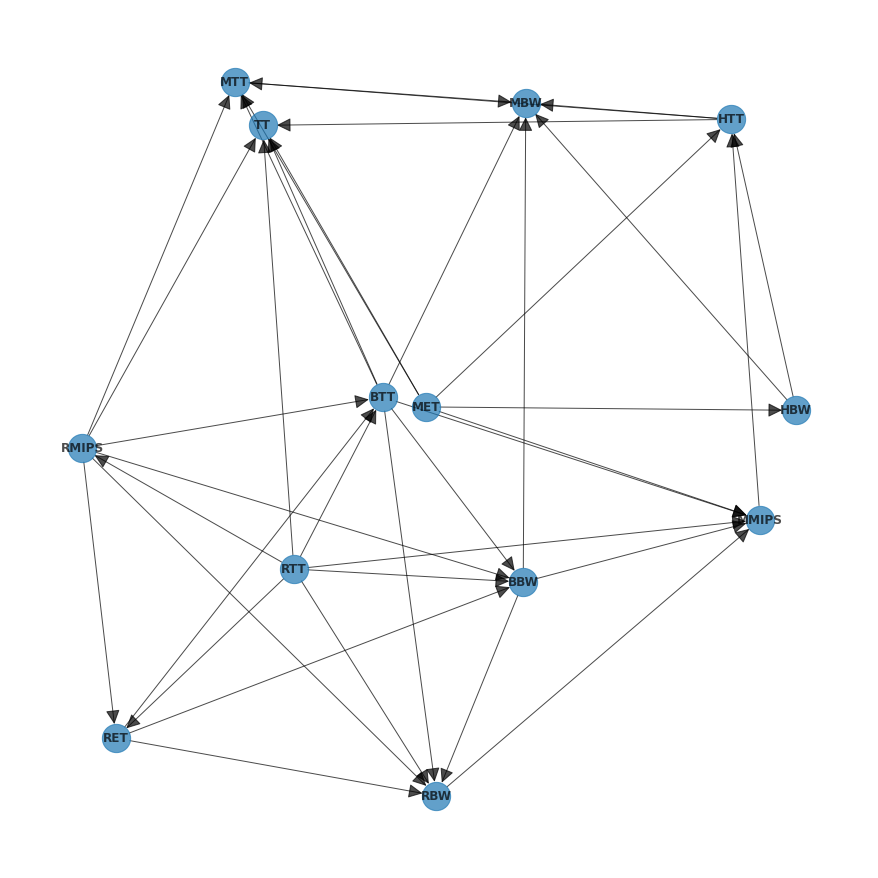

In [191]:
plt.figure(3,figsize=(12,12)) 
G = nx.DiGraph()
G.add_edges_from(model.edges)
G.add_nodes_from(model.nodes)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, arrowsize=30, node_size=800, alpha=0.7, font_weight="bold")  # Draw the original graph
plt.show()

In [184]:
#print(f'Check model: {bayes_model.check_model()}\n')

file = open('CPDs.txt', 'w')

for cpd in model.get_cpds():
    file.write(f'CPT of {cpd.variable}:\n')
    file.write(f'{cpd}\n')
    # print(f'CPT of {cpd.variable}:')
    # print(cpd, '\n')

In [185]:
# cpd_list = model.get_cpds()

# for cpd in cpd_list:

#     values = cpd.

#     df = pd.DataFrame(values, columns=cpd.variables)
    #print(values)

In [186]:
# print(f'Check model: {model.check_model()}\n')
# for cpd in model.get_cpds():
#     print(f'CPT of {cpd.variable}:')
#     print(cpd, '\n')

In [187]:
# column_names_list = [x for x in cat_df.columns]

# y = pd.get_dummies(cat_df.TT, prefix='TT')

# y.head()

In [188]:
# from sklearn.preprocessing import OneHotEncoder

# #creating instance of one-hot-encoder
# encoder = OneHotEncoder(handle_unknown='ignore')

# encoder_df = pd.DataFrame(encoder.fit_transform(cat_df[[x for x in cat_df.columns]]).toarray())

# encoder_df.head()

In [189]:
# import bnlearn as bn

# ohe_df, other = bn.df2onehot(cat_df)

# other.head()


#ohe_df.head()


In [190]:
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

f1 = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
acc = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
pr = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=cat_df, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
ls = log_likelihood_score(model=model, data=cat_df)
ss = structure_score(model=model, data=cat_df, scoring_method='bdeu')


print(f'F1 score: {f1}')
print(f'Accuracy score: {acc}')
print(f'Precision score: {pr}')
print(f'Recall score: {recall}')
print(f'Log-likilihood score: {ls}')
print(f'Strcture score: {ss}')

F1 score: 0.6
Accuracy score: 0.7948717948717948
Precision score: 1.0
Recall score: 0.42857142857142855
Log-likilihood score: -11647.656878372656
Strcture score: -12074.828821107558
